In [165]:
import pandas as pd
import numpy as np
import pricey as pr
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
import seaborn as sns
import arviz as az

from sklearnex import patch_sklearn
patch_sklearn()

# import warnings
# warnings.filterwarnings(action='ignore')

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

import pymc as pm
# import aesara as asr
from aesara import shared
import pytensor

az.style.use("arviz-darkgrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
# import matplotlib.pyplot as plt
 
# # 한글 폰트 사용을 위해서 세팅
# from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

In [61]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ

['005930',
 '005935',
 '000660',
 '006400',
 '006405',
 '051910',
 '051915',
 '005380',
 '005385',
 '035420',
 '068270',
 '000270',
 '035720',
 '105560',
 '005490',
 '055550',
 '207940',
 '012330',
 '373220',
 '028260',
 '086790',
 '033780',
 '066570',
 '066575',
 '096770',
 '316140',
 '017670',
 '034730',
 '003550',
 '030200',
 '009150',
 '259960',
 '036570',
 '323410',
 '000810',
 '009830',
 '015760',
 '032830',
 '051900',
 '010130',
 '011200',
 '003490',
 '034020',
 '003670',
 '011070',
 '018260',
 '402340',
 '028050',
 '009540',
 '010950',
 '010140',
 '352820',
 '047810',
 '097950',
 '090430',
 '034220',
 '021240',
 '000100',
 '035250',
 '086280',
 '032640',
 '251270',
 '000720',
 '011170',
 '267250',
 '004020',
 '024110',
 '161390',
 '377300',
 '010620',
 '005830',
 '011780',
 '008770',
 '383220',
 '271560',
 '006800',
 '329180',
 '071050',
 '012450',
 '018880',
 '078930',
 '016360',
 '011790',
 '001450',
 '139480',
 '010060',
 '128940',
 '138930',
 '004170',
 '030000',
 '302440',

In [62]:
_dflist = [fdr.DataReader(code, '2019-01-01') for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [63]:
p = pd.concat([_s['Close'] for _s in _dflist], axis=1)
p.columns = univ
logp = np.log(p); logp.head()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,10.564886,10.360912,11.012050,12.257241,11.359774,12.727838,12.162643,11.643954,11.136048,11.678440,...,11.901583,11.716111,8.930230,9.888374,10.089386,9.335209,9.684398,9.148465,9.170560,11.653661
2019-01-03,10.534759,10.335270,10.963012,12.220961,11.326596,12.700769,12.136187,11.665647,11.153389,11.711776,...,11.845820,11.704033,8.909100,9.849559,10.079623,9.311813,9.697693,9.152711,9.178850,11.653991
2019-01-04,10.530762,10.323841,10.973357,12.211060,11.304671,12.708362,12.122691,11.691072,11.161949,11.740061,...,11.820410,11.724077,8.916238,9.880731,10.087225,9.330343,9.736547,9.154828,9.176266,11.651600
2019-01-07,10.564886,10.376611,10.980195,12.287653,11.357441,12.745486,12.154779,11.699405,11.159104,11.786762,...,11.904968,11.739822,8.930230,9.935471,10.101313,9.337678,9.764800,9.151121,9.170039,11.652009
2019-01-08,10.547970,10.338511,10.988677,12.294541,11.363265,12.764259,12.173033,11.691072,11.154821,11.775290,...,11.877569,11.739822,8.924124,9.987369,10.094934,9.325542,9.760194,9.146335,9.174195,11.650773


In [64]:
p_open = pd.concat([_s['Open'] for _s in _dflist], axis=1)
p_open.columns = univ; p_open.tail()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-03,64000,54300,89700,750000,338000,728000,318000,184600,94600,203500,...,183200,80600,8750,15660,32785,13070,14600,12780,11770,112000
2023-04-04,63400,53800,85700,740000,337000,717000,320500,184000,94700,198200,...,173500,80200,8730,15570,32555,12910,14615,12955,11820,111680
2023-04-05,63700,53300,84300,730000,343500,722000,323500,185100,94100,201000,...,172300,80600,8900,15730,32680,13015,14695,13195,11860,111960
2023-04-06,63500,53400,83900,764000,345500,728000,327000,186900,94900,198200,...,171500,79900,8940,15400,32720,13350,14610,13190,11900,112120
2023-04-07,63800,54100,87900,742000,340000,720000,321000,185400,94300,193000,...,171100,80200,8950,15090,32510,13210,14630,13115,11920,113300


In [419]:
pairs = [
    ['005930', '005935'], # 삼성전자
    ['066570', '066575'], # LG전자
    ['006400', '006405'], # 삼성SDI
    ['051910', '051915'], # LG화학
    ['005380', '005385'], # 현대차
]

_from, _to = '2019-01-01', '2023-01-31'

stock1_name, stock2_name = pairs[0]
orig_data = logp.loc[_from:_to,[stock1_name, stock2_name]]
p_data = p.loc[_from:_to,[stock1_name, stock2_name]]
p_open_data = p_open.loc[_from:_to,[stock1_name, stock2_name]]

data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

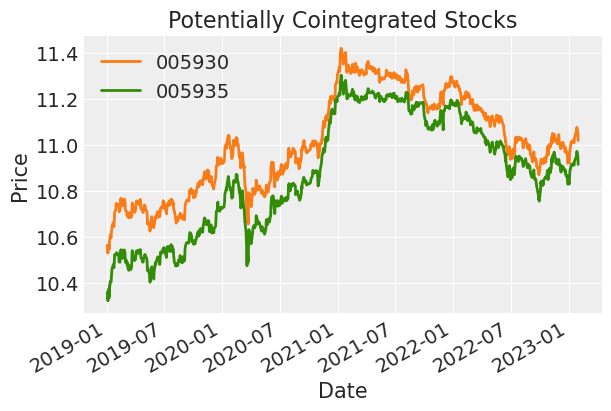

In [420]:
plt.figure(figsize = (6,4))
ax = plt.gca()
plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
orig_data[stock2_name].plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Price")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

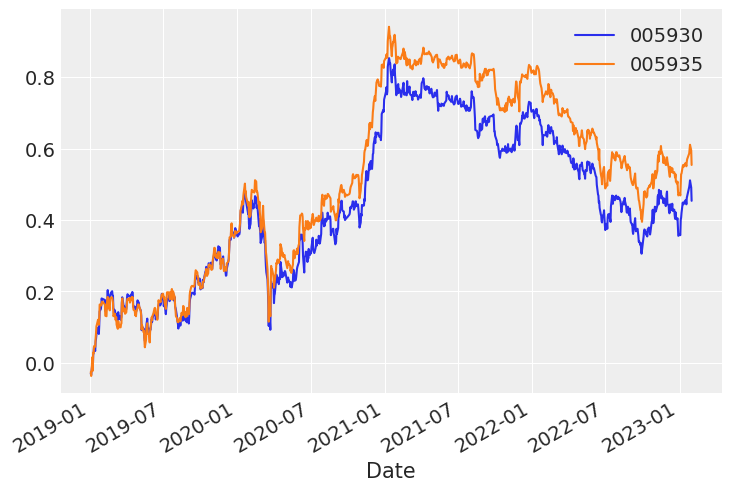

In [421]:
data[[stock1_name, stock2_name]].plot()

In [422]:
data.shape

(1008, 2)

In [423]:
with pm.Model() as model:
    
#     stock1 = data1
#     stock2 = data2
    
    stock1 = pytensor.shared(data1)
    stock2 = pytensor.shared(data2)
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, shape=data1.shape[0], init_dist=pm.Normal.dist(0, 10))
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sigma=.1)
    likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)

with model:
    stock1.set_value(data1)
    stock2.set_value(data2)
    idata = pm.sample(chains=2, cores=8, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [beta_sigma, beta, sd]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [429]:
# with pm.Model() as model:
#     model.add_coord('dates', data.index[:250], mutable = True)
#     stock1 = pm.MutableData('stock1', data1[:250], dims='dates')
#     stock2 = pm.MutableData('stock2', data2[:250], dims='dates')
    
#     beta_sigma = pm.Exponential('beta_sigma', 50.)
#     beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, init_dist=pm.Normal.dist(0, 10), dims='dates')
    
#     stock2_regression = beta * stock1
#     sd = pm.HalfNormal('sd', sigma=.1)
#     likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)
    
#     idata = pm.sample(chains=2, cores=8, random_seed=0)
    
    
# with model:
#     for i in range(2):
#         pm.set_data({
#             'stock1': [data1[600]],
#             'stock2': [data2[600]]
#         }, coords={ 'dates': [600] })

#     #     idata.extend(pm.sample_posterior_predictive(idata))
# #         idata2 = pm.sample(chains=2, cores=8, random_seed=0)
#         idata3 = pm.sample_prior_predictive(samples=1000, random_seed=0)    

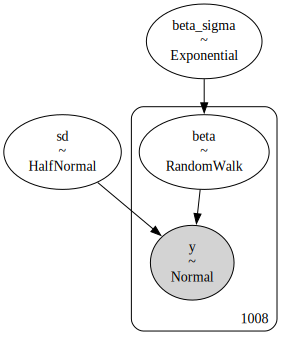

In [239]:
pm.model_to_graphviz(model)

In [424]:
# rolling_beta = idata.posterior['beta'].T.mean(axis=1)[:,0]#.mean(axis=1)
rolling_beta = idata.posterior['beta'].mean(dim=['draw','chain'])

In [255]:
rolling_beta[:5]

<xarray.DataArray 'beta' (beta_dim_0: 5)>
array([1.15323512, 1.15307677, 1.15427329, 1.15603126, 1.15741844])
Coordinates:
    chain       int64 0
  * beta_dim_0  (beta_dim_0) int64 0 1 2 3 4

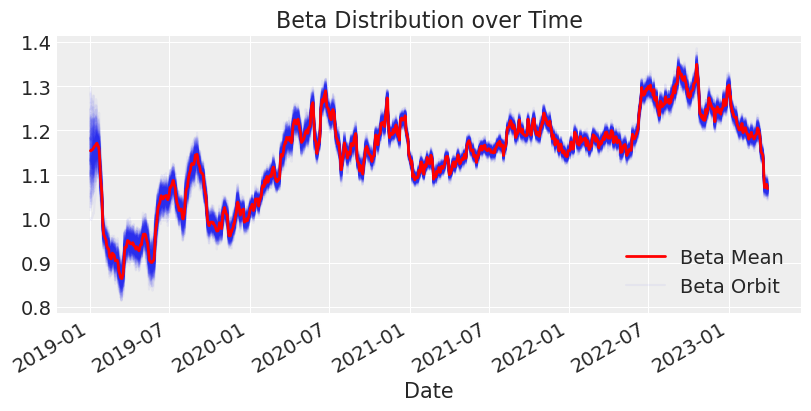

In [408]:
plt.figure(figsize = (8,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)

for orbit in idata.posterior['beta'].sel(draw=slice(0,200))[0]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
    

plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

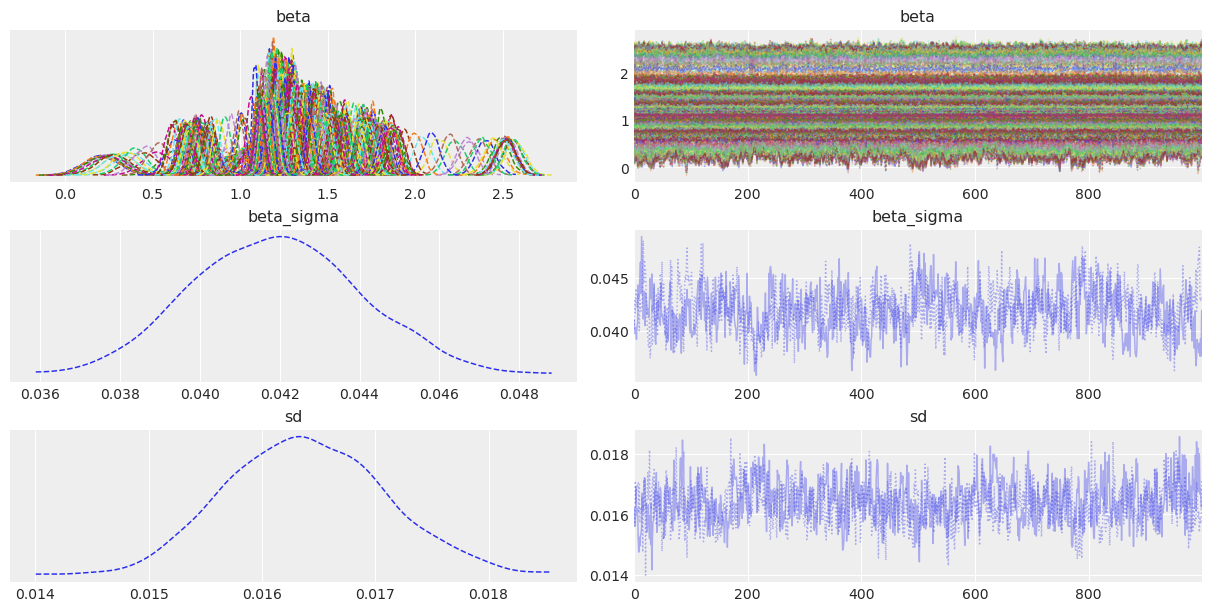

In [21]:
az.plot_trace(idata, combined=True);

In [409]:
def getStrategyPortfolioWeights(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    signal_spot = pd.Series(np.zeros(data1.shape[0]), index=data.index)
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()
            
            signal_spot[i] = smoothed_signal[i]

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                #leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
                #leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)
                
                w0 = -fixed_beta / (abs(fixed_beta)+1)
                w1 = 1 / (abs(fixed_beta)+1)
                
                w_max = max(abs(w0), abs(w1))
                
                leverage.iloc[i,0] = w0 / w_max
                leverage.iloc[i,1] = w1 / w_max
                
                trading = "short"
                trading_start = smoothed_signal[i]
                
            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0

        elif trading=="short":
            signal_spot[i] = smoothed_signal[i]
            
            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage.fillna(0), signal_spot

In [410]:
def backtest(pricingDF, openDF, leverageDF, start_cash):
    pricing = pricingDF.values
    pricing_open = openDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = cash[1] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    
    total_cost = 0
    pnl_hist = np.zeros(pricing.shape[0])
    pnl = []
    values = np.zeros(pricing.shape[0])
    values[0] = values[1] = start_cash

    
    for t in range(2, pricing.shape[0]):
        if np.any(leverage[t-1] != leverage[t-2]):
            target_shares = (start_cash * leverage[t-1] / pricing[t-1]).astype(int)
            
            # rebalance
            shares[t] = target_shares
            cost0 = abs(shares[t,0] - shares[t-1,0]) * pricing_open[t,0] * 0.0001
            cost1 = abs(shares[t,1] - shares[t-1,1]) * pricing_open[t,1] * (0.00025 if shares[t,1] > shares[t-1,1] else 0.00225)

            cash[t] = cash[t-1] - ((shares[t]-shares[t-1]) * pricing_open[t]).sum() - cost0 - cost1
            total_cost += (cost0 + cost1)
            #set_trace()
            
        else:
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
            
        values[t] = (shares[t] * pricing[t]).sum() + cash[t]
            
        if shares[t-1,0]==0 and shares[t,0]!=0:
            pnl_hist[t] = values[t] - values[t-1]
            
        elif shares[t,0]!=0 or (shares[t-1,0]!=0 and shares[t,0]==0):
            pnl_hist[t] = pnl_hist[t-1] + values[t] - values[t-1]
            
        if shares[t-1,0]!=0 and shares[t,0]==0:
            pnl.append(pnl_hist[t])
    
    
    pct_returns = (values - start_cash) / start_cash
    
    n_days = pct_returns.shape[0]
    net_profit = int(values[-1] - start_cash)
    net_return = pct_returns[-1] * 100
    total_cost_rate = total_cost / (net_profit + total_cost) * 100
    n_entry = len(pnl)
    n_entry_monthly = n_entry / n_days * 20
    n_entry_days = (portfolioWeights.iloc[:,0] != 0).sum()
    n_holding_days = n_entry_days / n_entry
    pnl_by_entry = net_profit / n_entry
    profit_of_profit_entry = np.mean(list(filter(lambda x: x>0, pnl)))
    loss_of_loss_entry = np.mean(list(filter(lambda x: x<0, pnl)))

    print(f'테스트 일수: {n_days}일')
    print(f'순손익 (투자금액대비%): {format(net_profit, ",")}원 ({net_return:.3f}%)')
    print(f'총비용 (총손익대비%): {format(int(total_cost), ",")}원 ({total_cost_rate:.3f}%)')
    print(f'진입횟수: {n_entry}회')
    print(f'월평균 진입횟수: {n_entry_monthly:.2f}회')
    print(f'진입일수 (전체일수대비%): {n_entry_days}일 ({n_entry_days/n_days*100:.2f}%)')
    print(f'평균보유일수: {n_holding_days:.2f}일')
    print(f'진입당 평균손익: {format(int(pnl_by_entry), ",")}원')
    print(f'최대수익: {format(int(max(pnl)), ",")}원')
    print(f'최대손실: {format(int(min(pnl)), ",")}원')
    print(f'수익진입의 평균수익: {format(int(profit_of_profit_entry), ",")}원')
    print(f'손실진입의 평균손실: {format(int(loss_of_loss_entry), ",")}원')
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index),
        pd.Series(values, index=pricingDF.index),
        pd.Series(pnl_hist, index=pricingDF.index),
        pd.Series(pnl)
    )

In [425]:
portfolioWeights, signal = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=1)#.fillna(0)
# portfolioWeights.plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

In [418]:
portfolioWeights.to_excel('w0.xlsx')

In [428]:
portfolioWeights.to_excel('w1.xlsx')

<Axes: xlabel='Date'>

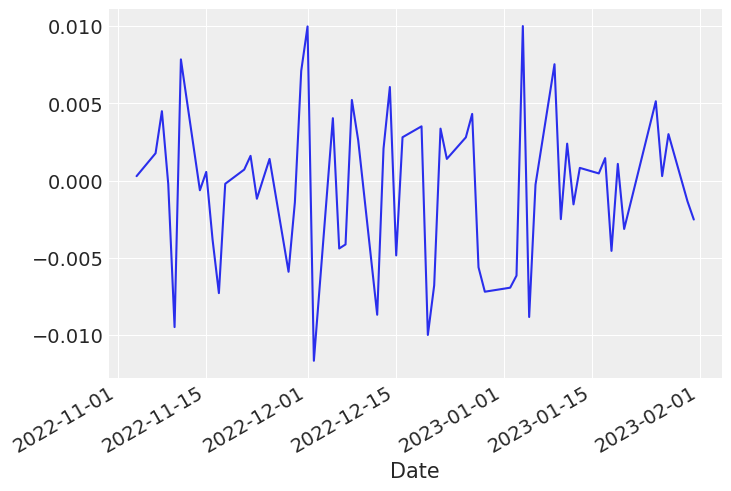

In [426]:
signal.tail(60).plot()

In [218]:
#portfolioWeights.sum(axis=1).plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

# 삼성전자

테스트 일수: 1050일
순손익 (투자금액대비%): 27,488,246원 (27.488%)
총비용 (총손익대비%): 25,851,753원 (48.466%)
진입횟수: 109회
월평균 진입횟수: 2.08회
진입일수 (전체일수대비%): 121일 (11.52%)
평균보유일수: 1.11일
진입당 평균손익: 252,185원
최대수익: 2,822,662원
최대손실: -1,452,407원
수익진입의 평균수익: 839,919원
손실진입의 평균손실: -392,061원


<Axes: xlabel='Date'>

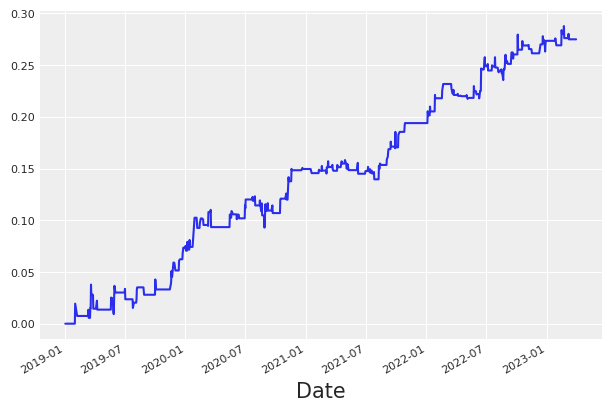

In [417]:
shares0, cash0, returns0, values0, pnl_hist0, pnl0 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns0.plot(figsize=(6,4), fontsize=8)

테스트 일수: 1008일
순손익 (투자금액대비%): 26,923,301원 (26.923%)
총비용 (총손익대비%): 25,414,348원 (48.558%)
진입횟수: 107회
월평균 진입횟수: 2.12회
진입일수 (전체일수대비%): 119일 (11.81%)
평균보유일수: 1.11일
진입당 평균손익: 251,619원
최대수익: 2,822,662원
최대손실: -1,452,407원
수익진입의 평균수익: 820,845원
손실진입의 평균손실: -397,297원


<Axes: xlabel='Date'>

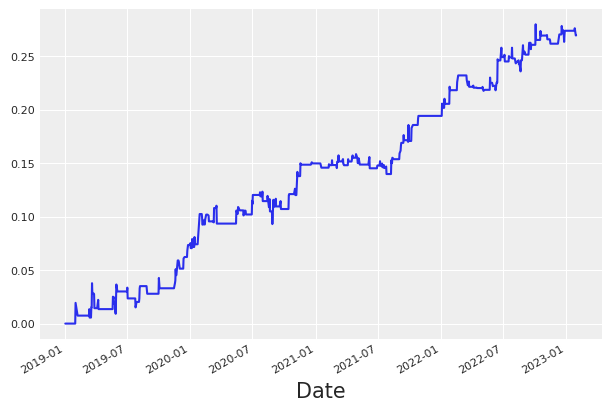

In [427]:
shares0, cash0, returns0, values0, pnl_hist0, pnl0 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns0.plot(figsize=(6,4), fontsize=8)

# LG전자

테스트 일수: 1050일
순손익 (투자금액대비%): 43,450,984원 (43.451%)
총비용 (총손익대비%): 25,112,915원 (36.627%)
진입횟수: 105회
월평균 진입횟수: 2.00회
진입일수 (전체일수대비%): 152일 (14.48%)
평균보유일수: 1.45일
진입당 평균손익: 413,818원
최대수익: 3,784,633원
최대손실: -4,097,088원
수익진입의 평균수익: 1,169,306원
손실진입의 평균손실: -864,698원


<Axes: xlabel='Date'>

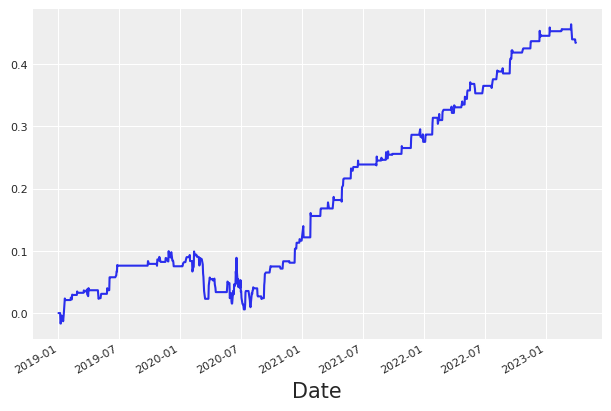

In [182]:
shares1, cash1, returns1, values1, pnl_hist1, pnl1 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns1.plot(figsize=(6,4), fontsize=8)

테스트 일수: 1050일
순손익 (투자금액대비%): 37,210,247원 (37.210%)
총비용 (총손익대비%): 26,177,352원 (41.297%)
진입횟수: 109회
월평균 진입횟수: 2.08회
진입일수 (전체일수대비%): 158일 (15.05%)
평균보유일수: 1.45일
진입당 평균손익: 341,378원
최대수익: 16,243,824원
최대손실: -2,988,487원
수익진입의 평균수익: 1,477,805원
손실진입의 평균손실: -816,093원


<Axes: xlabel='Date'>

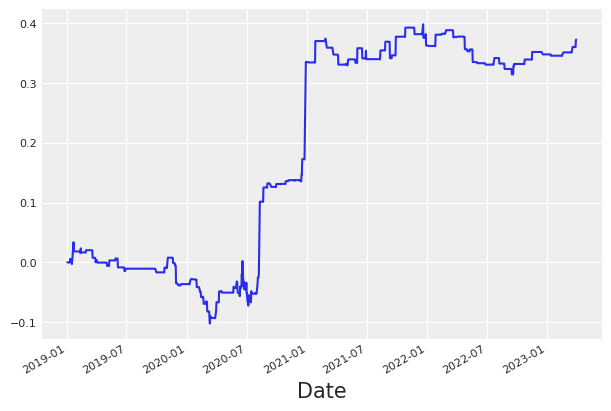

In [46]:
shares1, cash1, returns1, values1, pnl_hist1, pnl1 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns1.plot(figsize=(6,4), fontsize=8)

# 삼성SDI

테스트 일수: 1050일
순손익 (투자금액대비%): 99,971,044원 (99.971%)
총비용 (총손익대비%): 24,201,355원 (19.490%)
진입횟수: 107회
월평균 진입횟수: 2.04회
진입일수 (전체일수대비%): 160일 (15.24%)
평균보유일수: 1.50일
진입당 평균손익: 934,308원
최대수익: 11,341,820원
최대손실: -1,692,487원
수익진입의 평균수익: 1,792,894원
손실진입의 평균손실: -759,013원


<Axes: xlabel='Date'>

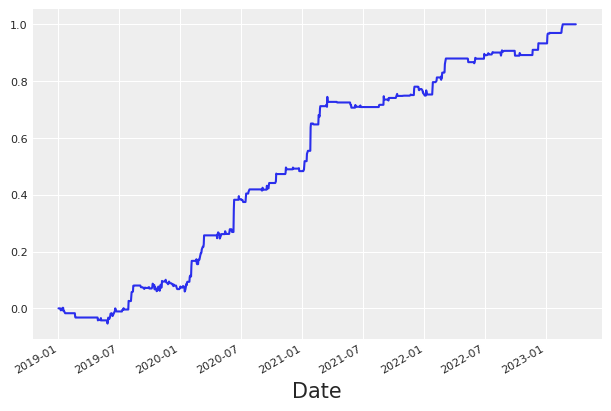

In [190]:
shares2, cash2, returns2, values2, pnl_hist2, pnl2 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns2.plot(figsize=(6,4), fontsize=8)

테스트 일수: 1050일
순손익 (투자금액대비%): 89,579,825원 (89.580%)
총비용 (총손익대비%): 23,914,074원 (21.071%)
진입횟수: 106회
월평균 진입횟수: 2.02회
진입일수 (전체일수대비%): 158일 (15.05%)
평균보유일수: 1.49일
진입당 평균손익: 845,092원
최대수익: 21,704,820원
최대손실: -2,453,518원
수익진입의 평균수익: 1,918,304원
손실진입의 평균손실: -856,340원


<Axes: xlabel='Date'>

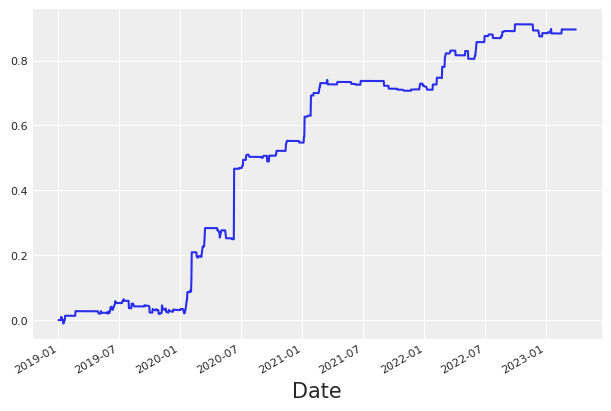

In [55]:
shares2, cash2, returns2, values2, pnl_hist2, pnl2 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns2.plot(figsize=(6,4), fontsize=8)

# LG화학

테스트 일수: 1050일
순손익 (투자금액대비%): 92,754,892원 (92.755%)
총비용 (총손익대비%): 31,814,607원 (25.540%)
진입횟수: 126회
월평균 진입횟수: 2.40회
진입일수 (전체일수대비%): 208일 (19.81%)
평균보유일수: 1.65일
진입당 평균손익: 736,149원
최대수익: 23,576,002원
최대손실: -8,629,714원
수익진입의 평균수익: 2,162,930원
손실진입의 평균손실: -1,582,368원


<Axes: xlabel='Date'>

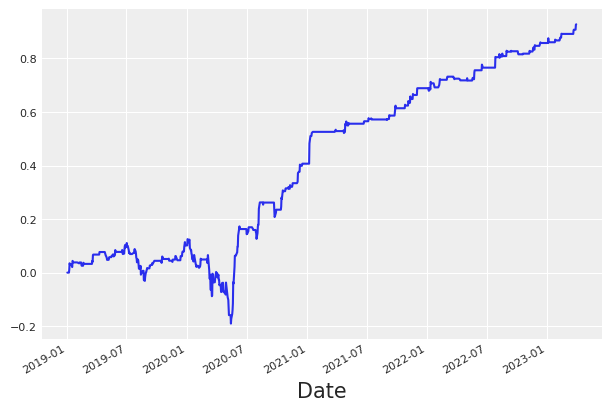

In [198]:
shares3, cash3, returns3, values3, pnl_hist3, pnl3 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns3.plot(figsize=(6,4), fontsize=8)

# 현대차

테스트 일수: 1050일
순손익 (투자금액대비%): 33,829,007원 (33.829%)
총비용 (총손익대비%): 34,846,992원 (50.741%)
진입횟수: 134회
월평균 진입횟수: 2.55회
진입일수 (전체일수대비%): 184일 (17.52%)
평균보유일수: 1.37일
진입당 평균손익: 252,455원
최대수익: 9,893,634원
최대손실: -4,021,175원
수익진입의 평균수익: 1,128,597원
손실진입의 평균손실: -837,552원


<Axes: xlabel='Date'>

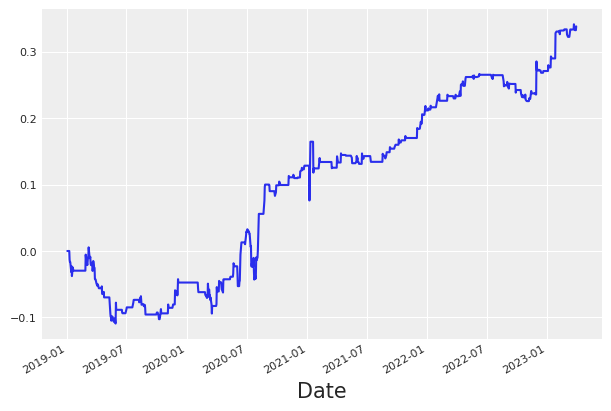

In [206]:
shares4, cash4, returns4, values4, pnl_hist4, pnl4 = backtest(p_data, p_open_data, portfolioWeights, 1e8)
returns4.plot(figsize=(6,4), fontsize=8)

<Axes: xlabel='Date'>

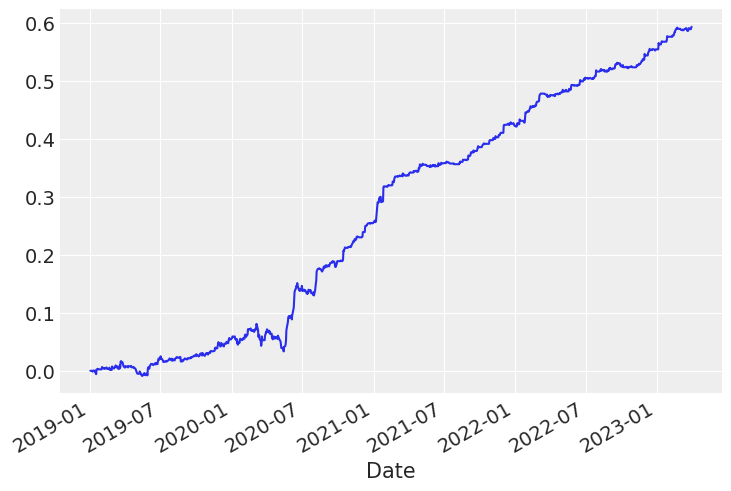

In [207]:
total_values = values0 + values1 + values2 + values3 + values4
((total_values / total_values.iloc[0]) - 1).plot()

<Axes: xlabel='Date'>

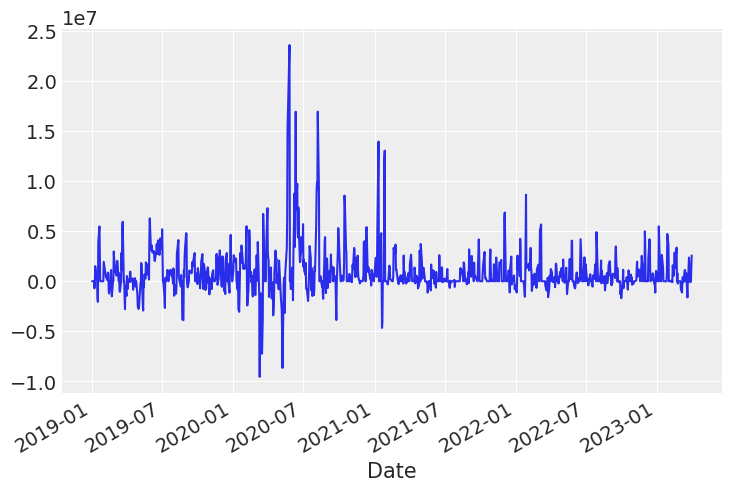

In [208]:
(pnl_hist0 + pnl_hist1 + pnl_hist2 + pnl_hist3 + pnl_hist4).plot()